In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Dataset dari Kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("filipkin/steam-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/steam-reviews


In [3]:
import tensorflow as tf

# List physical GPUs available to TensorFlow
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")

2025-05-31 11:13:34.521371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748690014.963763      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748690015.071771      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available: 2


In [4]:
df = pd.read_csv('/kaggle/input/steam-reviews/output.csv')
df.head()

,id,app_id,content,author_id,is_positive
0,181331361,100,At least its a counter strike -1/100,76561199556485100,Negative
1,180872601,100,Uh... So far my playthrough has not been great...,76561199230620391,Negative
2,177836246,100,Better mechanics than cs2,76561198417690647,Negative
3,177287444,100,buggy mess and NOT fun to play at all,76561199077268730,Negative
4,176678990,100,"Whoever came up with this, is gonna fucking ge...",76561199104544266,Negative


# Data Exploration

In [5]:
df.describe()

,id,app_id,author_id
count,2.011510e+05,201151.000000,2.011510e+05
mean,1.224624e+08,452.899722,7.656120e+16
std,5.896154e+07,322.187389,5.423023e+08
min,2.090000e+02,10.000000,7.656120e+16
25%,7.292665e+07,240.000000,7.656120e+16
50%,1.479831e+08,440.000000,7.656120e+16
75%,1.690541e+08,620.000000,7.656120e+16
max,1.822350e+08,1930.000000,7.656120e+16


Terlihat bahwa terdapat review dengan bahasa inggris, demi kemudahan training akan dilakukan preprocessing sehingga hanya menggunakan review dengan bahasa inggris

In [6]:
df.value_counts()

id         app_id  content                                                                                                                                                            author_id          is_positive
182235002  550     15 years later and still going on strong. speaks volumes about how good of a game this is. 10/10                                                                   76561199075519655  Positive       1
209        30      製品とかになる前にANC鯖とか中野鯖などで死ぬほどやった\nCSのストイックさというか死んだら終わり的な展開が嫌だったのも好きな一因\n下手な新兵でもそれなりに活躍できるゲーム性はいいとおもう\n\n個人的にはSorce版より泥臭い感じがして初代の方が好み                                   76561197960267615  Positive       1
210        40      マップとかまんまQuakeのDMなので懐かしさいっぱい\nFPS界の先輩に対するリスペクトってことでしょうか                                                                                                             76561197960267615  Positive       1
216        630     有料にしてきちんとmapリリースをしていけば良かったのに…。ハードコアco-op界からの刺客は死んだ。やり込みたい方は大本のUT2k4 modをどうぞ。                                      

In [61]:
df.shape

(201151, 5)

Terdapat beberapa missing values, perlu diremove segera

In [63]:
df.isna().sum()

id               0
app_id           0
content        428
author_id        0
is_positive      0
dtype: int64

In [67]:
df.dropna(subset=['content'],inplace=True)
df.drop('id',axis=1,inplace=True)

# EDA

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


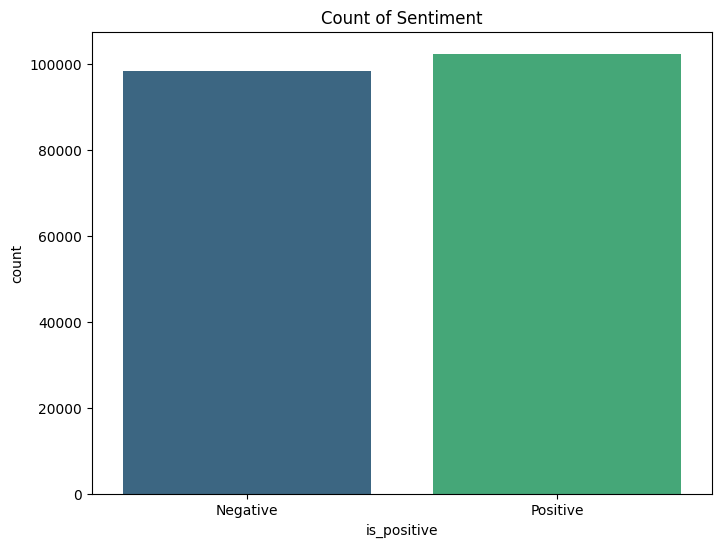

In [70]:
plt.figure(figsize=(8,6))
df['is_positive'] = df['is_positive'].astype('category')
sns.countplot(data=df, x='is_positive',palette= 'viridis')
plt.title("Count of Sentiment")
plt.show()

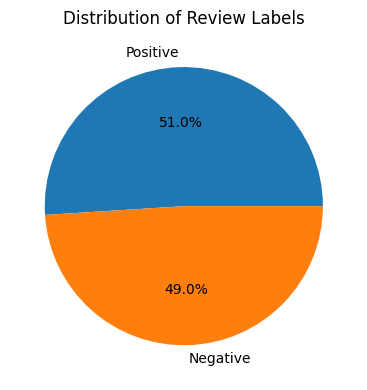

In [72]:
plt.figure(figsize=(7, 4))
df['is_positive'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Review Labels')
plt.ylabel('')
plt.tight_layout()
plt.show()

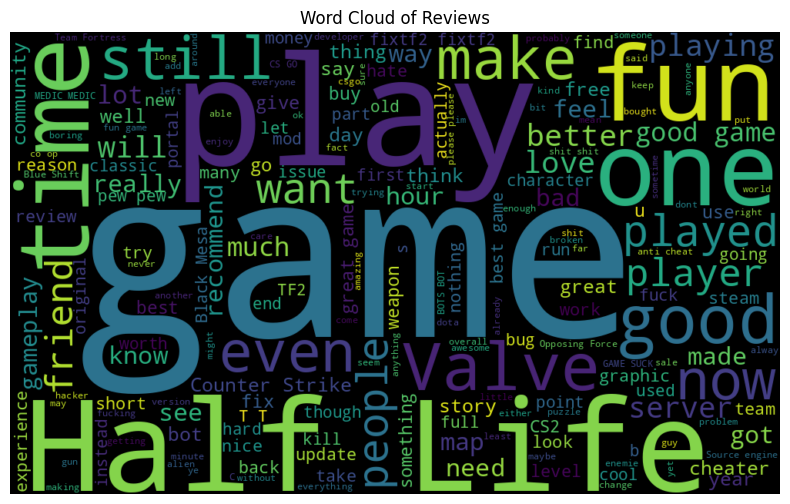

In [74]:
from wordcloud import WordCloud
all_content = " ".join(df['content'])
wordcloud = WordCloud(width=1000, height=600, background_color='black',colormap='viridis').generate(all_content)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

# Data Preprocessing

Drop id, app_id, dan author_id karena tidak digunakan

In [7]:
df1 = df.drop(columns = ['id','app_id','author_id'])
df1

,content,is_positive
0,At least its a counter strike -1/100,Negative
1,Uh... So far my playthrough has not been great...,Negative
2,Better mechanics than cs2,Negative
3,buggy mess and NOT fun to play at all,Negative
4,"Whoever came up with this, is gonna fucking ge...",Negative
...,...,...
201146,This trash for sick anime clowns!,Negative
201147,Not noob friendly,Negative
201148,Total trash for anime clowns!,Negative
201149,Unplayable. It keeps trying to update but then...,Negative


definisikan semua preprocessing seperti :
- re untuk pencocokan pola teks agar bisa dilakukan preprocess yang lain
- lower untuk mengubah semua huruf menjadi huruf kecil
- stopwords menghilangkan kata-kata umum yang sering diabaikan seperti "the","is", dan lainnya
- porterstemmer untuk stemming (pemotongan awalan dan akhiran)
- lemmatizer untuk lemmatization (pencarian bentuk dasar)

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

try:
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('stopwords', quiet=True)

    nltk.data.find('corpora/wordnet.zip') 
except Exception as e:
    print(f"Error during NLTK resource download or verification: {e}")
    print("Please ensure you have an internet connection and NLTK can download resources.")
    
    raise 


lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
stop_words = set(stopwords.words('english')) 

def clean_text(text):
    """
    Cleans the input text by removing HTML tags, URLs, and non-alphanumeric characters (except spaces).
    Converts text to lowercase.
    """
    if not isinstance(text, str):
        return "" # Or handle non-string input as you see fit

    # Remove HTML tags (if any)
    text = re.sub(r'<[^>]+>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers, keep only letters and spaces
    # This regex keeps letters and spaces, removes everything else.
    text = re.sub(r'[^a-z\s]', '', text)
    # Optional: Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    """
    Tokenizes the text into words.
    Input: text (string)
    Output: list of tokens (words)
    """
    if not text: # Handle empty string case after cleaning
        return []
    tokens = nltk.word_tokenize(text)
    return tokens

def remove_stopwords(tokens):
    """
    Removes stopwords from a list of tokens.
    Input: tokens (list of strings)
    Output: list of tokens without stopwords
    """
    if not tokens:
        return []
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

def lemmatize_tokens(tokens):
    """
    Lemmatizes a list of tokens.
    Input: tokens (list of strings)
    Output: list of lemmatized tokens
    """
    if not tokens:
        return []
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

def stem_tokens(tokens):
    """
    Stems a list of tokens using PorterStemmer.
    Input: tokens (list of strings)
    Output: list of stemmed tokens
    """
    if not tokens:
        return []
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

def preprocess_pipeline(raw_text):
    """
    Applies the full preprocessing pipeline to a single raw text string.
    """
    # 1. Clean text (lowercase, remove punctuation, numbers, HTML, URLs)
    cleaned_text = clean_text(raw_text)

    # 2. Tokenize
    tokens = tokenize_text(cleaned_text)

    # 3. Remove stopwords
    tokens_no_stopwords = remove_stopwords(tokens)

    # 4. Lemmatize (or Stem)
    processed_tokens = lemmatize_tokens(tokens_no_stopwords)

    return processed_tokens

Disini dilakukan pendeteksian bahasa, dan yang disimpan hanya bahasa inggris

In [9]:
!pip install langdetect
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# To ensure consistent results for short texts (optional but good practice)
DetectorFactory.seed = 0

def detect_language(text):
    try:
        # Ensure text is a string and not empty or just whitespace
        if not isinstance(text, str) or not text.strip():
            return "unknown" # Or None, or 'und' for undefined
        return detect(text)
    except LangDetectException:
        # This can happen if the text is too short or ambiguous
        return "unknown" # Or handle as you see fit

df1['language'] = df1['content'].apply(detect_language)

# See the distribution of detected languages
print("Language distribution in the dataset:")
print(df1['language'].value_counts())

# Filter to keep only English reviews
df_english_only = df1[df1['language'] == 'en'].copy() # Use .copy() to avoid SettingWithCopyWarning

print(f"\nOriginal dataset size: {len(df1)}")
print(f"Dataset size after keeping only English reviews: {len(df_english_only)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=b3caf0d136b595df29a8ec1833a6426878e0b6dfc86166f29e991d3beaf78aaf
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
Language distribution in the dataset:
language
en         142747
so           6029
unknown      4853
de           3907
tl           3093
ca           2889
af           2478
da           2450
cy           2295
no           2291
es           2224
ru           2178
sq           1841
pt           1832
tr           1779
nl           1676
it           1574
fr           1460
pl           1451
id           1429
ro           1324
et           1142
sl            900
sv            844
hr            830
vi            824
sw            779
fi            727
hu            586
sk

In [39]:
df_english_only.to_csv('english_reviews_only.csv', index=False)

apply semua preprocess di bagian ini

In [10]:
df_english_only['processed_tokens'] = df_english_only['content'].apply(preprocess_pipeline)

# Create a string version of processed tokens for Keras Tokenizer
df_english_only['processed_text_str'] = df_english_only['processed_tokens'].apply(lambda tokens: ' '.join(tokens))

print("Sample of processed English text:")
print(df_english_only[['content', 'processed_text_str']].head())

Sample of processed English text:
                                             content  \
0               At least its a counter strike -1/100   
1  Uh... So far my playthrough has not been great...   
2                          Better mechanics than cs2   
3              buggy mess and NOT fun to play at all   
4  Whoever came up with this, is gonna fucking ge...   

                                  processed_text_str  
0                               least counter strike  
1  uh far playthrough great glitched texture cont...  
2                                  better mechanic c  
3                                buggy mess fun play  
4  whoever came gon na fucking get negative revie...  


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

encoding positive/negative menjadi [1,0]

In [12]:
label_encoder = LabelEncoder()
df_english_only['sentiment_numeric'] = label_encoder.fit_transform(df_english_only['is_positive'])

print(f"Label mapping: {list(label_encoder.classes_)} -> {label_encoder.transform(label_encoder.classes_)}")

labels = df_english_only['sentiment_numeric'].values

Label mapping: ['Negative', 'Positive'] -> [0 1]


Splitting Train dan test

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_english_only['processed_text_str'],
                                                    df_english_only['sentiment_numeric'],
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Shape of new X_train: {X_train.shape}")
print(f"Shape of new X_test: {X_test.shape}")

Shape of new X_train: (114197,)
Shape of new X_test: (28550,)


# Word2vec
Word2Vec secara sederhana adalah sebuah teknik atau model dalam Natural Language Processing (NLP) yang bertujuan untuk mengubah kata-kata menjadi representasi angka (vektor). Vektor-vektor ini disebut juga word embeddings atau "vektor kata".

Inti dari Word2Vec adalah ide bahwa makna sebuah kata dapat dipelajari dari konteks di mana kata tersebut sering muncul. Ada pepatah dalam linguistik: "Anda akan mengenali sebuah kata dari kawanannya"

W2V_VECTOR_SIZE = 100: Menentukan dimensi dari vektor kata yang akan dihasilkan. Artinya, setiap kata dalam kosakata Anda akan direpresentasikan sebagai vektor numerik dengan 100 angka. Dimensi ini harus cocok dengan output_dim pada layer Embedding di model Keras Anda nanti.

W2V_WINDOW = 5: Ini adalah ukuran jendela konteks. Saat melatih, Word2Vec akan melihat kata-kata dalam "jendela" ini di sekitar kata target untuk memahami konteksnya. Nilai 5 berarti model akan mempertimbangkan 5 kata sebelum dan 5 kata sesudah kata target (jika sg=1, atau sebaliknya jika sg=0).

W2V_MIN_COUNT = 1: Kata-kata yang muncul dalam korpus data latih Anda kurang dari W2V_MIN_COUNT kali akan diabaikan dan tidak dimasukkan ke dalam kosakata model Word2Vec. Nilai 1 berarti semua kata yang muncul setidaknya sekali akan dimasukkan.

W2V_WORKERS = 4: Menentukan jumlah thread pekerja yang akan digunakan untuk melatih model. Menggunakan beberapa thread dapat mempercepat proses pelatihan pada mesin dengan multi-core CPU.

W2V_SG = 0: Parameter ini memilih algoritma pelatihan Word2Vec:

0: Menggunakan CBOW (Continuous Bag-of-Words). CBOW mencoba memprediksi kata target berdasarkan kata-kata di sekitarnya (konteksnya). Biasanya lebih cepat dan baik untuk kata-kata yang sering muncul.

1: Menggunakan Skip-gram. Skip-gram mencoba memprediksi kata-kata di sekitar (konteks) berdasarkan kata target. Biasanya lebih lambat tetapi bekerja lebih baik untuk kata-kata yang jarang muncul dan dataset yang lebih besar.

W2V_EPOCHS = 10: Jumlah epoch atau iterasi yang akan dilakukan model Word2Vec atas keseluruhan dataset pelatihan. Semakin banyak epoch, model memiliki lebih banyak kesempatan untuk mempelajari representasi vektor kata, tetapi terlalu banyak juga bisa menyebabkan overfitting pada data Word2Vec itu sendiri.

In [47]:
from gensim.models import Word2Vec
W2V_VECTOR_SIZE = 100  # Dimensionality of the word vectors (must match Embedding layer output_dim)
W2V_WINDOW = 5         # Context window size
W2V_MIN_COUNT = 1      # Minimum word count to be included in Word2Vec vocabulary
W2V_WORKERS = 4        # Number of worker threads
W2V_SG = 0             # 0 for CBOW, 1 for Skip-gram
W2V_EPOCHS = 10        # Number of epochs to train Word2Vec

print("Preparing text for Word2Vec...")
tokenized_texts_for_w2v = [text.split() for text in X_train]
print(f"First few tokenized texts for Word2Vec: {tokenized_texts_for_w2v[:2]}")

print("\nTraining Word2Vec model...")
# Note: For Word2Vec to be effective, you generally need a substantial corpus.
# If your dataset is small, the learned embeddings might not be very robust.
word2vec_model = Word2Vec(
    sentences=tokenized_texts_for_w2v,
    vector_size=W2V_VECTOR_SIZE,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=W2V_WORKERS,
    sg=W2V_SG,
    epochs=W2V_EPOCHS
)
print("Word2Vec model training complete.")
print(f"Word2Vec vocabulary size: {len(word2vec_model.wv.index_to_key)}")

Preparing text for Word2Vec...
First few tokenized texts for Word2Vec: [['short', 'sweet', 'nice', 'little', 'coverup', 'distract', 'u', 'impossible', 'existence', 'half', 'life', 'since', 'game', 'company', 'count', 'two'], ['zombiepew', 'pew', 'swing', 'swing', 'thats', 'al', 'game', 'need']]

Training Word2Vec model...
Word2Vec model training complete.
Word2Vec vocabulary size: 57954


Tokenizer disini digunakan untuk membangun kosakata unik, serta mengubah teks menjadi urutan(sekuens) angka berdasarkan kosakata yang telah dibangun tersebut

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150
OOV_TOKEN = "<oov>"

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token=OOV_TOKEN)

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
keras_vocab_size = len(word_index) + 1
vocab_size = len(word_index) + 1 
print(f"Found {len(word_index)} unique English tokens. Vocab size for embedding: {vocab_size}")

Found 57955 unique English tokens. Vocab size for embedding: 57956


tokenizer akan mengubah text menjadi format numerik dengan panjang yang seragam, sudah siap untuk input model deep learning

pad_sequence untuk membuat semua urutan angka memiliki panjang yang sama, sehingga menjadi sebuah array numpy 2d, setiap sekuens memiliki panjang yang seragam

In [50]:
# Convert texts to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post',
                                 truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post',
                                 truncating='post')
print(f"Shape of x training padded sequences: {X_train_padded.shape}")
print(f"Shape of x testing padded sequences: {X_test_padded.shape}")

Shape of x training padded sequences: (114197, 150)
Shape of x testing padded sequences: (28550, 150)


Menginisialisasi weights dengan vektor kata yang telah dilatih sebelumnya menggunakan word2vec

In [51]:
print("\nCreating embedding matrix...")
embedding_matrix = np.zeros((keras_vocab_size, W2V_VECTOR_SIZE)) # +1 for padding index 0

skipped_words_count = 0
for word, i in word_index.items():
    if i >= keras_vocab_size: # Should not happen if keras_vocab_size = len(word_index) + 1
        continue
    if word in word2vec_model.wv:
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[i] = embedding_vector
    else:
        skipped_words_count += 1
        if word == OOV_TOKEN:
             print(f"'{OOV_TOKEN}' was not in Word2Vec model. Its embedding will be zeros.")

print(f"Shape of embedding matrix: {embedding_matrix.shape}")
print(f"Number of words in Keras Tokenizer not found in Word2Vec model: {skipped_words_count}")



Creating embedding matrix...
'<oov>' was not in Word2Vec model. Its embedding will be zeros.
Shape of embedding matrix: (57956, 100)
Number of words in Keras Tokenizer not found in Word2Vec model: 1


In [52]:
np.bincount(y_train)

array([58242, 55955])

# Model Building

In [53]:
import tensorflow as tf
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(input_dim=vocab_size, # Use your actual vocab_size
#                               output_dim=64, # Increased embedding dimension, experiment with this
#                               input_length=MAX_SEQUENCE_LENGTH if MAX_SEQUENCE_LENGTH else None), # Optional if all sequences are already padded to a fixed length known at model build time
#     tf.keras.layers.LSTM(units=64,
#                          dropout=0.3, # Dropout on input/output gates
#                          recurrent_dropout=0.3, # Dropout on recurrent connections
#                          return_sequences=False), # Only return the last output
#     # Removed Flatten layer as LSTM with return_sequences=False outputs (batch_size, units)
#     tf.keras.layers.Dense(128,
#                           activation='relu',
#                           kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Switched to L2, or keep L1
#     tf.keras.layers.Dropout(0.5), # Increased dropout rate after dense layer
#     tf.keras.layers.Dense(64,
#                           activation='relu',
#                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.Dropout(0.5),
#     # Output Layer: Assuming 3 classes
#     # If labels are integers (0, 1, 2), this is fine with sparse_categorical_crossentropy
#     # If labels are one-hot encoded, use categorical_crossentropy
#     # If binary classification (0 or 1), use Dense(1, activation='sigmoid') and binary_crossentropy
#     tf.keras.layers.Dense(1,activation='sigmoid')
# ])
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=W2V_VECTOR_SIZE,weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32,dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
optimizer = tf.keras.optimizers.Adam() 
# --- Compilation for Binary Classification ---
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       5,795,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,795,600 (22.11 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,795,600 (22.11 MB)

# Checkpoint

In [55]:
checkpoint_dir = 'tmp/checkpoint' # This can be the base directory
model_filepath = f'{checkpoint_dir}/best_model.keras'
import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

CustomCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_filepath, # Consider saving as .keras e.g. 'tmp/checkpoint/best_binary_model.keras'
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5, # Number of epochs with no improvement
        restore_best_weights=True,
        verbose=1
    )
]

# Training Model  

In [56]:
num_epochs = 10
batch_size = 128

history = model.fit(
    X_train_padded,               # Training input data
    y_train,               # Training labels
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded, y_test), # Validation data and labels
    callbacks=CustomCallbacks,    # Your list of callbacks
    verbose=2
)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.76564, saving model to tmp/checkpoint/best_model.keras
893/893 - 298s - 334ms/step - accuracy: 0.6188 - loss: 0.6418 - val_accuracy: 0.7656 - val_loss: 0.5479
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.76564
893/893 - 294s - 329ms/step - accuracy: 0.7060 - loss: 0.5982 - val_accuracy: 0.7353 - val_loss: 0.5701
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.76564
893/893 - 292s - 327ms/step - accuracy: 0.6910 - loss: 0.6048 - val_accuracy: 0.7066 - val_loss: 0.5875
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.76564
893/893 - 291s - 326ms/step - accuracy: 0.5827 - loss: 0.6627 - val_accuracy: 0.5834 - val_loss: 0.6636
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.76564
893/893 - 293s - 328ms/step - accuracy: 0.6406 - loss: 0.6367 - val_accuracy: 0.6787 - val_loss: 0.6111
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.76564
893/893 - 292s - 327ms/step - accuracy: 0.6706 - los

# Visualisasi Evaluasi Model

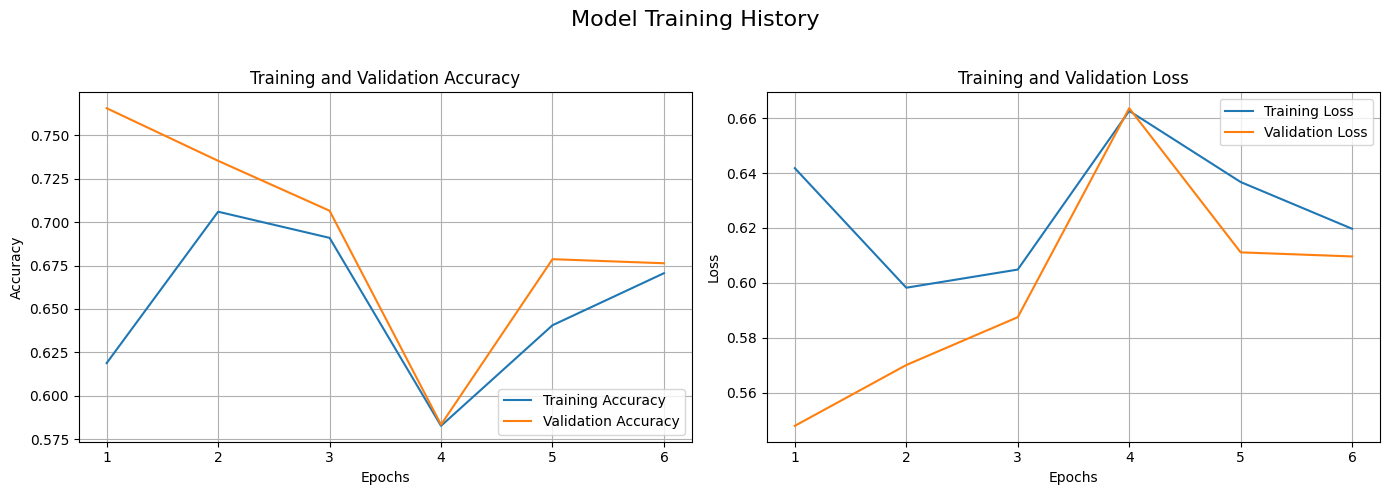

In [57]:
import matplotlib.pyplot as plt

acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

if acc is None or val_acc is None or loss is None or val_loss is None:
    print("Error: Could not retrieve all necessary metrics from history.history.")
    print("Available keys:", history.history.keys())
    print("Ensure your model was compiled with 'accuracy' metric and validation_data was provided during fit.")
else:
    epochs_range = range(1, len(acc) + 1) # Create a range of epochs for the x-axis

    plt.figure(figsize=(14, 5)) # Adjust figure size as needed

    plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True) # Add a grid for easier reading

    plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True) # Add a grid

    plt.suptitle('Model Training History', fontsize=16) # Overall title for the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

Test Loss: 0.5479
Test Accuracy (from model.evaluate): 76.56%
------------------------------------------------------------
893/893 ━━━━━━━━━━━━━━━━━━━━ 68s 76ms/step
Test Accuracy (from sklearn.metrics): 76.56%
------------------------------------------------------------
Confusion Matrix:
[[11756  2878]
 [ 3813 10103]]


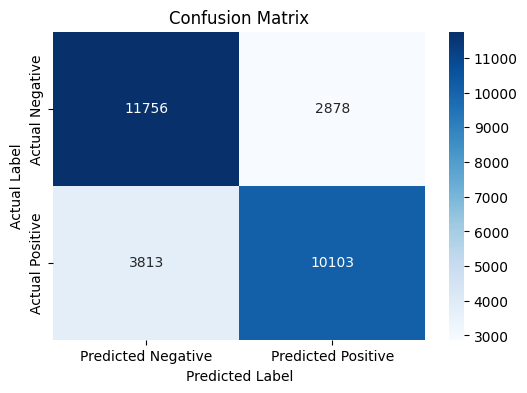

------------------------------------------------------------
Classification Report:
                          precision    recall  f1-score   support

Class 0 (e.g., Negative)       0.76      0.80      0.78     14634
Class 1 (e.g., Positive)       0.78      0.73      0.75     13916

                accuracy                           0.77     28550
               macro avg       0.77      0.76      0.76     28550
            weighted avg       0.77      0.77      0.77     28550

------------------------------------------------------------
Precision (for positive class): 0.7783
Recall (for positive class): 0.7260
F1-Score (for positive class): 0.7512


In [58]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

loss, accuracy_on_test = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy (from model.evaluate): {accuracy_on_test*100:.2f}%")
print("-" * 60)

y_pred_proba = model.predict(X_test_padded)

# Convert probabilities to class labels (0 or 1) using a 0.5 threshold
y_pred_classes = (y_pred_proba > 0.5).astype("int32").flatten() # .flatten() if y_pred_proba is (n_samples, 1)

# Ensure y_test is also a flat array if it's not already
y_test_flat = y_test.flatten() if y_test.ndim > 1 else y_test

accuracy_sklearn = accuracy_score(y_test_flat, y_pred_classes)
print(f"Test Accuracy (from sklearn.metrics): {accuracy_sklearn*100:.2f}%")
print("-" * 60)

# 4. Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# For a nicer plot of the confusion matrix:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
print("-" * 60)

# 5. Classification Report
# This provides precision, recall, f1-score, and support for each class.
# Assuming your LabelEncoder mapped 'Negative' to 0 and 'Positive' to 1 (check your label_encoder.classes_)
# target_names = ['Negative', 'Positive'] # Or use label_encoder.classes_
try:
    # If you have label_encoder defined and fitted from previous steps:
    # target_names = label_encoder.classes_
    # If not, define them manually based on your 0/1 mapping
    target_names = ['Class 0 (e.g., Negative)', 'Class 1 (e.g., Positive)']
except NameError:
    target_names = ['Class 0', 'Class 1']


report = classification_report(y_test_flat, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(report)
print("-" * 60)
# You can also print individual precision, recall, f1-score if needed
precision = precision_score(y_test_flat, y_pred_classes)
recall = recall_score(y_test_flat, y_pred_classes)
f1 = f1_score(y_test_flat, y_pred_classes)
print(f"Precision (for positive class): {precision:.4f}")
print(f"Recall (for positive class): {recall:.4f}")
print(f"F1-Score (for positive class): {f1:.4f}")

In [66]:
label_map = {0: "Negative", 1: "Positive"} 
# If your mapping is different (e.g., 0: "Positive", 1: "Negative"), change this dictionary.

# --- 1. How many random samples do you want to see? ---
num_samples_to_predict = 10 # You can change this number

# --- 2. Get random indices from your test set ---
if len(X_test_padded) == 0:
    print("Error: X_test_padded is empty. Please load your test data.")
elif len(X_test_padded) < num_samples_to_predict:
    print(f"Warning: Requested {num_samples_to_predict} samples, but test set only has {len(X_test_padded)} samples. Showing all.")
    sample_indices = np.arange(len(X_test_padded))
else:
    sample_indices = np.random.choice(len(X_test_padded), num_samples_to_predict, replace=False)

# --- 3. Get the actual data for these sampled indices ---
if sample_indices.size > 0: # Proceed only if we have samples
    # --- 3. Get the actual data for these sampled POSITIONS ---
    sampled_X_padded = X_test_padded[sample_indices] # This is fine as X_test_padded is a NumPy array

    # For pandas Series, use .iloc for positional access
    if isinstance(y_test, pd.Series):
        sampled_y_true_numeric = y_test.iloc[sample_indices].values # .values to get NumPy array
    elif isinstance(y_test, np.ndarray):
        sampled_y_true_numeric = y_test[sample_indices]
    else: # Convert to NumPy array if it's a list or other
        sampled_y_true_numeric = np.array(y_test)[sample_indices]

sampled_texts = []
if isinstance(X_test, pd.Series):
    try:
        sampled_texts = X_test.iloc[sample_indices].tolist()
    except IndexError: # Fallback if sample_indices don't align with a potentially non-0-based index from iloc
         print("Attempting to use sample_indices directly on X_test_texts (assuming it's a list or NumPy array now).")
         temp_X_test_texts_list = X_test.tolist()
         sampled_texts = [temp_X_test_texts_list[i] for i in sample_indices]

elif isinstance(X_test_texts, list) or isinstance(X_test_texts, np.ndarray):
    # If X_test_texts is a list or numpy array, direct indexing with sample_indices (if they are positions) works
    # (Ensure X_test_texts was converted to list/array after split if it was a Series with non-sequential index)
    temp_X_test_texts_list = list(X_test_texts)
    sampled_texts = [temp_X_test_texts_list[i] for i in sample_indices]
else:
    print(f"Warning: X_test_texts is of type {type(X_test_texts)}. Text display might be incorrect if not a pandas Series, list, or NumPy array.")
    # Create placeholder texts if type is unknown
    sampled_texts = [f"Text for index {idx} not retrievable (check X_test_texts format)" for idx in sample_indices]


# --- 4. Make predictions on these samples ---
# model.predict() returns probabilities for the positive class (due to sigmoid output)
predicted_scores = model.predict(sampled_X_padded).ravel() # .ravel() to make it a 1D array

# Convert probabilities to class labels (0 or 1) using a 0.5 threshold
predicted_classes_numeric = (predicted_scores > 0.5).astype(int)


# --- 5. Display the results ---
print(f"\n--- Predictions for {len(sampled_texts)} Random Test Samples ---")
for i in range(len(sampled_texts)):
    text = sampled_texts[i]
    true_label_num = sampled_y_true_numeric[i]
    pred_score = predicted_scores[i]
    pred_label_num = predicted_classes_numeric[i]

    true_label_str = label_map.get(true_label_num, f"Unknown_Label_({true_label_num})")
    pred_label_str = label_map.get(pred_label_num, f"Unknown_Label_({pred_label_num})")

    print(f"\nSample Review (Original Index in X_test_padded: {sample_indices[i]}):")
    print(f"Text: \"{text[:300]}...\"") # Show first 300 characters
    print(f"True Sentiment    : {true_label_str} (Numeric: {true_label_num})")
    print(f"Predicted Score   : {pred_score:.4f} (Raw output for positive class)")
    print(f"Predicted Sentiment: {pred_label_str} (Numeric: {pred_label_num})")
    
    if true_label_num == pred_label_num:
        print("Result: CORRECT")
    else:
        print("Result: INCORRECT")
    print("-" * 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

--- Predictions for 10 Random Test Samples ---

Sample Review (Original Index in X_test_padded: 15271):
Text: "one fun game due wide variety mode plus play friend mod basically fun game pas time..."
True Sentiment    : Positive (Numeric: 1)
Predicted Score   : 0.7586 (Raw output for positive class)
Predicted Sentiment: Positive (Numeric: 1)
Result: CORRECT
----------------------------------------

Sample Review (Original Index in X_test_padded: 10641):
Text: "best game ever wheres portal..."
True Sentiment    : Positive (Numeric: 1)
Predicted Score   : 0.7586 (Raw output for positive class)
Predicted Sentiment: Positive (Numeric: 1)
Result: CORRECT
----------------------------------------

Sample Review (Original Index in X_test_padded: 22915):
Text: "real shotgun toe create handle new game ask input arbitrary password though im aware game choose generate random password character lower upper number within next minute game show fictional email wh

In [59]:
print("\nAttempting TFLite conversion with suggested flags...")
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # --- Fixes suggested by your error messages: ---

    # Suggestion 1: Enable resource variables
    # This can help with how variables are handled during conversion.
    converter.experimental_enable_resource_variables = True

    # Suggestion 2: Use Select TF Ops and disable experimental TensorList lowering
    # This is often the key fix for LSTM-related TensorList errors.
    # It allows the TFLite model to include certain TensorFlow operations if they
    # don't have a direct TFLite built-in equivalent.
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TFLite builtin ops
        tf.lite.OpsSet.SELECT_TF_OPS     # Enable Select TF ops (to use TF ops when needed)
    ]
    # This flag specifically tells the converter not to try and lower (convert)
    # TensorList operations into simpler TFLite ops, using TF ops instead.
    converter._experimental_lower_tensor_list_ops = False

    # Optional: Apply default optimizations.
    # You can try conversion with and without this line.
    # If conversion fails with optimizations, try without it first, then re-add if successful.
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Perform the conversion
    tflite_model_content = converter.convert()
    print("TensorFlow Lite model conversion successful!")

    # --- 3. Save the TensorFlow Lite model to a .tflite file ---
    tflite_model_filename = 'sentiment_model_fixed.tflite'
    with open(tflite_model_filename, 'wb') as f:
        f.write(tflite_model_content)
    print(f"TFLite model saved as {tflite_model_filename}")

except Exception as e:
    print(f"An error occurred during TFLite conversion: {e}")
    print("\n--- Full Traceback ---")
    import traceback
    traceback.print_exc()
    print("----------------------")
    print("\nIf issues persist, ensure your TensorFlow version is up to date (tf.<strong>version</strong>).")
    print("Sometimes, these conversion issues are resolved in newer TensorFlow releases.")


Attempting TFLite conversion with suggested flags...
Saved artifact at '/tmp/tmp8xbu7jhm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133321650725968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133321650727504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133321650732496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133321650979664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133321650732880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133321650979280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133321650980432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133321650980240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133321650981200: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1748701371.914639      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748701371.914677      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


TensorFlow Lite model conversion successful!
TFLite model saved as sentiment_model_fixed.tflite


In [60]:
import json
# Assuming 'tokenizer' is your Keras Tokenizer object that has been fitted
# For example:
# from tensorflow.keras.preprocessing.text import Tokenizer
# MAX_VOCAB_SIZE = 10000 # Or your actual vocab size
# OOV_TOKEN = "<oov>"
# tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token=OOV_TOKEN)
# tokenizer.fit_on_texts(X_train_texts) # CRITICAL: Fitted ONLY on training text

# This is the dictionary you need:
word_to_index_map = tokenizer.word_index

# Define the OOV token string you used (must match what Flutter will use)
# This was defined when you created the Tokenizer instance.
# If tokenizer.oov_token is None, then you didn't set one, which is less ideal.
oov_token_string = tokenizer.oov_token if tokenizer.oov_token else "<unk>" # Fallback if not set

print(f"Total words in tokenizer's word_index: {len(word_to_index_map)}")

# Check if your specific OOV token string has an entry in the word_index
# Keras Tokenizer handles OOV mapping, but for Flutter, you'll need this index explicitly
# if you want to map unknown words to your specific <oov> token's index.
if oov_token_string in word_to_index_map:
    print(f"Your OOV token '{oov_token_string}' is in the word_index with index: {word_to_index_map[oov_token_string]}")
else:
    # This might happen if MAX_VOCAB_SIZE is small and <oov> wasn't in the top words,
    # or if <oov> wasn't in the training text.
    # Keras Tokenizer internally might still map to an OOV index (often 1 if num_words is set).
    # For Flutter, you'll need a strategy: either ensure <oov> gets into your word_index.json
    # or handle words not in the map by assigning a default OOV index (e.g., a specific integer).
    print(f"Warning: Your OOV token string '{oov_token_string}' was not found directly in the exported word_index.")
    print(f"You might need to explicitly handle unknown words in Flutter by assigning a default OOV index (e.g., the index for the token Keras uses for OOV, or 0 if that's your plan).")
    # Keras Tokenizer usually assigns index 1 to OOV if num_words is restrictive.
    # You can check tokenizer.get_config()['oov_token_index'] if available and relevant.

try:
    with open('word_index.json', 'w', encoding='utf-8') as f:
        json.dump(word_to_index_map, f, ensure_ascii=False, indent=4)
    print("\nSuccessfully saved 'word_index.json'")
    print(f"This file contains {len(word_to_index_map)} word-to-index mappings.")
    print("You will need to load this JSON file in your Flutter app.")

    # Also remind yourself of these constants for your Flutter app:
    # MAX_SEQUENCE_LENGTH = 150 # The value you used
    # print(f"\nRemember for your Flutter app:")
    # print(f"  MAX_SEQUENCE_LENGTH = {MAX_SEQUENCE_LENGTH}")
    # print(f"  The OOV token string you'll look for: '{oov_token_string}'")
    # print(f"  Padding value is typically 0.")

except Exception as e:
    print(f"Error saving word_index.json: {e}")


Total words in tokenizer's word_index: 57955
Your OOV token '<oov>' is in the word_index with index: 1

Successfully saved 'word_index.json'
This file contains 57955 word-to-index mappings.
You will need to load this JSON file in your Flutter app.
